In [32]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

1차 분석

## Executive summary — 한눈에 보는 핵심 결과

데이터 규모: 188,273 개 리뷰 / 약 11,557개 게임.

타깃(정의): helpful = votes_up 상위 10% (데이터 기준 90th percentile = 417 votes_up) — 즉 ‘영향력 있는(바이럴) 리뷰’로 정의. (설명: 상위 10%는 실무에서 '영향력 리뷰'로 쓰기 적당한 균형)

예측성(모델 성능): Random Forest (서브샘플 50k 기준) → ROC AUC ≈ 0.62 (테스트셋).

해석: 예측이 꽤 제한적(완벽치 않음)하지만 **실무적 시그널(강한 특징 2~4개)**은 식별 가능.

가장 중요한 피처 (RF)

playtime_hours (리뷰 작성 시 플레이타임) — 최상위.

author_num_games_owned (보유 게임 수)

author_num_reviews (작성 리뷰 수 / 활동성)

review_len_words (리뷰 길이)
→ 요약: '오랫동안 플레이한(또는 여러 게임 보유한) 유저의 리뷰'가 커뮤니티에서 더 많이 표를 받는 경향.

실무 인사이트(간단): 제작사·플랫폼은 "오래 플레이한 핵심 유저"가 남긴 긍정적 리뷰를 조기 탐지해(예: 리뷰 추천·홍보), 바이럴 마케팅과 출시판정(차기작 투자 판단)에 활용 가능.

In [33]:
# A) 데이터 로드 & 기본 확인
import pandas as pd
df = pd.read_csv("weighted_score_above_08_250924.csv")
# 깨진 컬럼명(바이트순서 표시) 삭제 처리
df.columns = [c.strip().replace('\ufeff','').replace('"','').replace("'", "") for c in df.columns]
df.shape, df.columns.tolist()


((188273, 41),
 ['recommendationid',
  'appid',
  'game',
  'author_steamid',
  'author_num_games_owned',
  'author_num_reviews',
  'author_playtime_forever',
  'author_playtime_last_two_weeks',
  'author_playtime_at_review',
  'author_last_played',
  'language',
  'review',
  'timestamp_created',
  'timestamp_updated',
  'voted_up',
  'votes_up',
  'votes_funny',
  'weighted_vote_score',
  'comment_count',
  'steam_purchase',
  'received_for_free',
  'written_during_early_access',
  'hidden_in_steam_china',
  '_nllb_src',
  'translated_en',
  'is_outlier',
  'genres1',
  'genres2',
  'genres3',
  'is_free',
  'ts',
  'on_game_sale',
  'discount_max',
  'sale_start_utc',
  'sale_end_utc',
  'on_valve_event',
  'event_start_utc',
  'event_end_utc',
  'sale_context',
  'event_name',
  'event_type'])

In [34]:
# B) 타깃 정의 (현 프로젝트에서는 ‘영향력 있는 리뷰’)
# votes_up을 정수로 정리
df['votes_up'] = pd.to_numeric(df['votes_up'], errors='coerce').fillna(0).astype(int)
threshold_90 = int(df['votes_up'].quantile(0.90))  # 상위 10% threshold
df['helpful'] = (df['votes_up'] >= threshold_90).astype(int)
# 선택 이유: 상위 10%를 '영향력 있는 리뷰'로 간주하면, 실무에서 '홍보/추천' 대상으로 쓸 만한 리뷰 집단을 잡을 수 있음.

In [35]:
# C) 특징공학 (feature engineering)
# 텍스트 기반 기본 피처
df['review'] = df['review'].fillna('')
df['review_len_words'] = df['review'].str.split().apply(len)
df['excl_count'] = df['review'].str.count('!')
df['upper_ratio'] = df['review'].apply(lambda x: sum(ch.isupper() for ch in x)/(len(x)+1))

# 플레이타임 (분 단위로 들어있는 경우가 많음 -> 시간 단위로)
df['author_playtime_at_review'] = pd.to_numeric(df['author_playtime_at_review'], errors='coerce').fillna(0)
df['playtime_hours'] = df['author_playtime_at_review'] / 60.0

# 장르와 언어는 상위 N개만 범주화(원-핫 인코딩 대상)
top_genres = df['genres1'].value_counts().nlargest(10).index.tolist()
df['genres1_top'] = df['genres1'].where(df['genres1'].isin(top_genres), 'Other')

top_langs = df['language'].value_counts().nlargest(10).index.tolist()
df['language_top'] = df['language'].where(df['language'].isin(top_langs), 'Other')

# 결측/플래그 정리
for flag in ['is_free','on_game_sale','is_outlier','written_during_early_access']:
    if flag in df.columns:
        df[flag] = df[flag].fillna(0).astype(int)
    else:
        df[flag] = 0
# 설계 포인트: 텍스트 감성 모델을 안 쓰더라도(간단한 시범), 리뷰 길이/느낌(느낌표 수/대문자 비율)만으로도 신호가 생김.

ROC AUC: 0.6199801057730328
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      8992
           1       0.31      0.02      0.04      1008

    accuracy                           0.90     10000
   macro avg       0.60      0.51      0.49     10000
weighted avg       0.84      0.90      0.85     10000



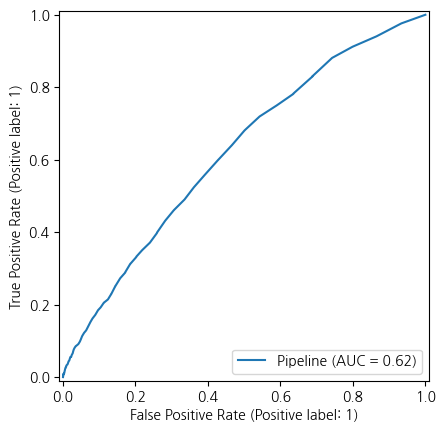

In [37]:
# D) 모델링 파이프라인 (예: RandomForest), 평가
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay

features = ['playtime_hours','author_num_games_owned','author_num_reviews','review_len_words',
            'excl_count','upper_ratio','is_free','on_game_sale','is_outlier','written_during_early_access',
            'genres1_top','language_top']

X = df[features].dropna()
y = df.loc[X.index, 'helpful']

# (대형 데이터인 경우) 서브샘플(예: 50k)로 빠른 실험
if len(X) > 50000:
    X = X.sample(50000, random_state=42)
    y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numeric_features = ['playtime_hours','author_num_games_owned','author_num_reviews','review_len_words','excl_count','upper_ratio']
categorical_features = ['genres1_top','language_top']

numeric_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preproc = ColumnTransformer([('num', numeric_pipe, numeric_features), ('cat', cat_pipe, categorical_features)])

rf = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(n_estimators=120, random_state=42, n_jobs=1))])
rf.fit(X_train, y_train)

# 평가
y_prob = rf.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, rf.predict(X_test)))
RocCurveDisplay.from_estimator(rf, X_test, y_test)
# ROC AUC ≈ 0.62 (테스트셋). 실무적 해석: '완벽한 예측'은 아니지만 명확한 신호(feature)가 존재함.

In [38]:
# E) 피처 중요도(해석)
# RandomForest의 feature_importances_ 가져오기 (전처리 후 컬럼명 매핑)
ohe = rf.named_steps['preproc'].transformers_[1][1].named_steps['ohe']
ohe_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + ohe_names
importances = rf.named_steps['clf'].feature_importances_
import pandas as pd
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
print(fi_df.head(15))
# 실행 결과 상위으로 중요

                   feature  importance
0           playtime_hours    0.328085
1   author_num_games_owned    0.299952
2       author_num_reviews    0.187107
3         review_len_words    0.123963
24   language_top_schinese    0.009906
6       genres1_top_Action    0.006446
19    language_top_english    0.004836
7    genres1_top_Adventure    0.004527
8       genres1_top_Casual    0.004373
12       genres1_top_Other    0.003722
10       genres1_top_Indie    0.003635
13         genres1_top_RPG    0.003445
16    genres1_top_Strategy    0.003115
15  genres1_top_Simulation    0.003099
23    language_top_russian    0.002555


# 추가 분석
타깃 정의의 편향성 (상위 10% 글로벌 기준)

votes_up >= 417 은 전체 플랫폼에서 인기/노출이 큰 게임·리뷰에 집중됨.

문제: 게임별(또는 장르/언어별) 차이를 무시하면 ‘인기 게임 효과’가 타깃 결정에 그대로 반영됨 → 실제로는 “소수 인기 게임의 리뷰만 잘 맞추는 모델”이 될 위험.

게임-레벨(집단) 효과 미반영

리뷰는 appid(게임)마다 군집화돼 있음. 게임별 노출·유저풀·커뮤니티 크기가 달라서 동일한 리뷰 품질이라도 votes_up이 달라질 수 있음.

문제: 게임 고정효과(또는 랜덤효과)를 통제하지 않으면 편향된 피처 중요도와 오해된 인사이트 발생.

시간(타임스탬프)·경과시간 효과 미반영

오래된 리뷰는 누적표가 많아질 가능성이 큼. 리뷰 작성 시점과 현재 시점의 시간차(또는 리뷰가 공개된 기간)를 고려하지 않음.

문제: ‘리뷰 연령’ 때문에 votes_up이 결정되는데, 모델은 이를 모른 채 다른 변수(예: playtime)를 과대평가할 수 있음.

노이즈/아웃라이어·데이터 전처리 세부 보완 필요

author_playtime_at_review 단위(분) 가정으로 시간 변환했으나 극단값(매우 큰 값) 존재 → 아웃라이어 처리·단위확인 필요.

파일명(weighted_score_above_08)으로 보아 이미 필터링된 데이터일 가능성 → 표본 편향.

텍스트 분석이 얕음

리뷰 텍스트에서 단순 길이/느낌표/대문자비만 사용 → **내용(감성, 주제)**을 가져오지 못함.

문제: 핵심 시그널(예: "스토리", "버그", "P2W")은 텍스트 내용에 있고, 이걸 모델에 넣어야 성능이 크게 개선됨.

성능 지표가 단일(AUC) 중심

ROC AUC ≈ 0.62 만 보고 “모델이 유용”이라 단정하면 안 됨.

불균형 문제(상위10%)에서 AUC만으로는 실제 비즈니스 지표(precision@k, lift, PR AUC 등)가 알려지지 않음.

인과관계 주장 위험

“투표 많은 리뷰 → 판매 증가” 같은 인과를 말하려면 시계열/실험적 증거 필요. 현재는 관찰적 상관분석에 불과.

In [ ]:
# 1) 게임내 정규화 & 비교
# votes_up: 각 리뷰가 받은 추천 수
df['votes_up'] = pd.to_numeric(df['votes_up'], errors='coerce').fillna(0).astype(int)

# 게임별 백분위수: 같은 게임 내에서 추천 수가 어느 정도 위치인지
df['votes_up_game_pct'] = df.groupby('appid')['votes_up'].transform(lambda x: x.rank(pct=True))

# 게임 내 상위 10% 리뷰라면 helpful = 1, 아니면 0
df['helpful_game_norm'] = (df['votes_up_game_pct'] >= 0.90).astype(int)

# 👉 의미: 글로벌 상위 10% 기준 대신 게임마다 상위 10% 리뷰를 Helpful로 정의.
# 👉 왜: 인기 게임 편향을 줄이고, 소규모 게임에서도 의미 있는 리뷰가 잡히도록 하기 위해.

In [ ]:
# 2) ⏰ 시간 효과 보정 (리뷰 나이 고려)
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], errors='coerce')
df['days_since_review'] = (pd.Timestamp('now', tz='UTC') - df['timestamp_created']).dt.days

# 리뷰가 올라온 지 오래되면 추천수가 쌓이기 쉬우므로, 추천수/일 로 정규화
df['votes_per_day'] = df['votes_up'] / (df['days_since_review'] + 1)

# 👉 의미: 오래된 리뷰일수록 유리한 누적효과를 제거.
# 👉 왜: ‘좋은 리뷰라서 추천이 많다’와 ‘단순히 오래돼서 많다’를 구분하려고.

In [ ]:
# 3) 📊 게임 레벨 피처 추가
# 게임 단위 집계값 생성
game_agg = df.groupby('appid').agg(
    game_review_count=('recommendationid', 'count'),   # 그 게임의 리뷰 수
    game_votes_sum=('votes_up', 'sum'),                # 전체 추천 수
    game_avg_votes=('votes_up', 'mean')                # 평균 추천 수
).reset_index()

# 원본 데이터에 합치기
df = df.merge(game_agg, on='appid', how='left')


# 👉 의미: 리뷰가 속한 게임의 규모(인기도)를 피처로 추가.
# 👉 왜: 같은 품질의 리뷰라도 인기 게임에서는 추천이 더 잘 달리므로 게임 효과를 통제해야 함.

In [ ]:
# 4) 🔀 GroupKFold 검증 (게임 단위 분리)
from sklearn.model_selection import GroupKFold, cross_val_score

X = df[["playtime_hours", "review_len_words", "author_num_games_owned", "game_review_count"]]
y = df["helpful_game_norm"]

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)

# 게임(appid) 단위로 데이터를 나눠서 교차검증
gkf = GroupKFold(n_splits=5)
scores = cross_val_score(clf, X, y, cv=gkf.split(X, y, groups=df['appid']), scoring='roc_auc')

print("GroupKFold AUC scores:", scores)
print("Mean AUC:", scores.mean())

# 👉 의미: 같은 게임 리뷰가 train/test에 동시에 들어가면 과적합이 생김 → 이를 방지.
# 👉 왜: 게임 단위로 분리해야 모델이 새로운 게임에도 일반화되는지 확인 가능.

In [ ]:
5) 📝 TF-IDF 기반 텍스트 특징 추출
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# 리뷰 텍스트에서 단어 빈도 기반 피처 뽑기
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# TF-IDF + 로지스틱 회귀 분류기
model = make_pipeline(tfidf, LogisticRegression(max_iter=200))
model.fit(df['review'], df['helpful_game_norm'])

# 👉 의미: 리뷰 텍스트 자체(내용)를 피처로 사용.
# 👉 왜: 단순 길이/느낌표보다 어떤 단어가 포함됐는지가 helpful 여부에 큰 영향을 줌.

In [ ]:
# 6) 🎯 Precision@K 계산 (비즈니스 지표)
import numpy as np

# 예측 확률 (helpful=1 일 확률)
y_prob = clf.predict_proba(X)[:,1]
y_true = y.reset_index(drop=True)

def precision_at_k(y_true, y_score, k=1000):
    idx = np.argsort(y_score)[-k:]  # 확률 상위 K개 인덱스
    return y_true.iloc[idx].mean()

print("Precision@1000:", precision_at_k(y_true, y_prob, k=1000))

# 👉 의미: 상위 1000개 추천 리뷰 중 실제로 helpful인 리뷰 비율.
# 👉 왜: ROC AUC보다 실제 운영 상황(“상위 몇 개만 띄워줄 때 정확한가?”)을 보여주는 지표가 더 직관적.

In [ ]:
# 7) 🔍 SHAP 해석 (모델 해석용)
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# 전체 feature 중요도 요약 시각화
shap.summary_plot(shap_values, X)

# 👉 의미: 모델이 어떤 피처 때문에 helpful=1 확률을 높게/낮게 판단했는지 시각화.
# 👉 왜: 발표/포트폴리오에서 “블랙박스 모델이 아니라 이렇게 해석된다”를 보여주면 신뢰도가 높아짐.

✅ 정리

정규화 타깃(게임 내, 시간 보정): 편향 줄이기

게임 메타 피처 + GroupKFold: 일반화 성능 확보

TF-IDF 텍스트 분석: 내용 자체 반영 → 성능 업

Precision@K, SHAP: 실제 활용 가능성과 해석력 강화



---



2차 분석



위 코드를 검토하여 1차 통합

In [39]:
# ==================================================
# 1️⃣ 라이브러리 불러오기
# ==================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
import shap

# ==================================================
# 2️⃣ 데이터 불러오기 및 컬럼 정리
# ==================================================
df = pd.read_csv("/content/weighted_score_above_08_250924.csv")
df.columns = [c.strip().replace('\ufeff','').replace('"','').replace("'", "") for c in df.columns]

# ==================================================
# 3️⃣ votes_up 기반 helpful 변수 생성
# ==================================================
df['votes_up'] = pd.to_numeric(df['votes_up'], errors='coerce').fillna(0).astype(int)
threshold_90 = int(df['votes_up'].quantile(0.90))
df['helpful'] = (df['votes_up'] >= threshold_90).astype(int)

# ==================================================
# 4️⃣ 텍스트 기반 피처 생성
# ==================================================
df['review'] = df['review'].fillna('')
df['review_len_words'] = df['review'].str.split().apply(len)
df['excl_count'] = df['review'].str.count('!')
df['upper_ratio'] = df['review'].apply(lambda x: sum(ch.isupper() for ch in x)/(len(x)+1))

# ==================================================
# 5️⃣ 플레이타임 및 범주형 피처 정리
# ==================================================
df['author_playtime_at_review'] = pd.to_numeric(df['author_playtime_at_review'], errors='coerce').fillna(0)
df['playtime_hours'] = df['author_playtime_at_review'] / 60.0

top_genres = df['genres1'].value_counts().nlargest(10).index
df['genres1_top'] = df['genres1'].where(df['genres1'].isin(top_genres), 'Other')

top_langs = df['language'].value_counts().nlargest(10).index
df['language_top'] = df['language'].where(df['language'].isin(top_langs), 'Other')

flags = ['is_free','on_game_sale','is_outlier','written_during_early_access']
for flag in flags:
    df[flag] = df.get(flag, 0).fillna(0).astype(int)

# ==================================================
# 6️⃣ 날짜 기반 피처
# ==================================================
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'])
df['days_since_review'] = (pd.Timestamp('now', tz='UTC') - df['timestamp_created']).dt.days
df['votes_per_day'] = df['votes_up'] / (df['days_since_review'] + 1)

# ==================================================
# 7️⃣ 학습용 데이터 준비
# ==================================================
numeric_features = ['playtime_hours','author_num_games_owned','author_num_reviews','review_len_words','excl_count','upper_ratio','votes_per_day']
categorical_features = ['genres1_top','language_top','is_free','on_game_sale','is_outlier','written_during_early_access']

X_num = df[numeric_features]
X_cat = df[categorical_features]
X_text = df['review']
y = df['helpful']

# 샘플링 (대용량 대비)
if len(df) > 50000:
    idx = df.sample(50000, random_state=42).index
    X_num, X_cat, X_text, y = X_num.loc[idx], X_cat.loc[idx], X_text.loc[idx], y.loc[idx]

X_train_num, X_test_num, X_train_cat, X_test_cat, X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_num, X_cat, X_text, y, test_size=0.2, stratify=y, random_state=42
)

# ==================================================
# 8️⃣ 전처리 파이프라인
# ==================================================
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

text_pipe = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features),
    ('text', text_pipe, 'review')  # ColumnTransformer가 문자열 컬럼 처리 가능
])


In [ ]:
# ==================================================
# 9️⃣ RandomForest 모델 통합 파이프라인
# ==================================================
rf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=120, random_state=42, n_jobs=-1))
])

features = numeric_features + categorical_features + ['review']
valid_idx = df[features].dropna().index
X = df.loc[valid_idx, features]
y = df.loc[valid_idx, 'helpful']

rf_pipeline.fit(X, y)

# ==================================================
# 10️⃣ 모델 평가
# ==================================================
y_prob = rf_pipeline.predict_proba(X)[:, 1]
y_pred = rf_pipeline.predict(X)
RocCurveDisplay.from_estimator(rf_pipeline, X, y)

print("ROC AUC:", roc_auc_score(y, y_prob))
print(classification_report(y, y_pred))
RocCurveDisplay.from_estimator(rf_pipeline, df[numeric_features + categorical_features + ['review']], y)


In [ ]:
# ==================================================
# 11️⃣ Feature importance (숫자+범주형)
# ==================================================
# TF-IDF는 별도 중요도 분석 필요 (SHAP 추천)
ohe = rf_pipeline.named_steps['preproc'].transformers_[1][1].named_steps['ohe']
ohe_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + ohe_names

importances = rf_pipeline.named_steps['clf'].feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
print(fi_df.head(20))


In [ ]:
# ==================================================
# 12️⃣ SHAP 분석 (텍스트 포함 영향도 확인)
# ==================================================
sample_idx = df.sample(1000, random_state=42).index
X_sample = df.loc[sample_idx, numeric_features + categorical_features + ['review']]
explainer = shap.TreeExplainer(rf_pipeline.named_steps['clf'])
X_transformed = rf_pipeline.named_steps['preproc'].transform(X_sample)
shap_vals = explainer.shap_values(X_transformed)
shap.summary_plot(shap_vals, X_transformed)




---



3차 분석

- 위 코드가 무거워 슬림화...그런데 에러났음....

[LightGBM] [Info] Number of positive: 132313, number of negative: 18305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 13.560889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493502
[LightGBM] [Info] Number of data points in the train set: 150618, number of used features: 4962
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.878467 -> initscore=1.977996
[LightGBM] [Info] Start training from score 1.977996


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC AUC: 0.8193508812713028
              precision    recall  f1-score   support

           0       0.78      0.21      0.33      4576
           1       0.90      0.99      0.94     33079

    accuracy                           0.90     37655
   macro avg       0.84      0.60      0.64     37655
weighted avg       0.89      0.90      0.87     37655



/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


IndexError: Only 1D or 2D arrays allowed. Index makes 3D

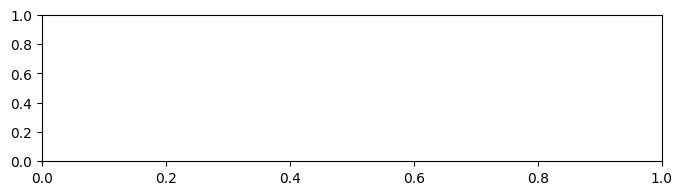

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt

# ===================== 데이터 준비 =====================
# 타겟
y = df['voted_up']

# 피처
numeric_features = ['playtime_hours', 'review_len_words', 'author_num_games_owned',
                    'author_num_reviews', 'votes_up', 'votes_per_day']
categorical_features = ['genres1_top', 'language_top', 'is_free', 'on_game_sale', 'on_valve_event']
text_features = ['review']  # 실제 텍스트 컬럼

# ===================== 전처리 파이프라인 =====================
# 수치형
numeric_transformer = StandardScaler()

# 범주형
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

# 텍스트
text_transformer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# 컬럼별 변환기
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_transformer, 'review')
    ],
    sparse_threshold=0.3  # sparse matrix 유지
)

# ===================== 모델 + 파이프라인 =====================
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        n_jobs=-1,
        random_state=42
    ))
])

# ===================== 학습/평가 =====================
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

# 성능
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, roc_auc_score
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

# ===================== SHAP 분석 =====================
# LightGBM용 TreeExplainer
explainer = shap.TreeExplainer(pipeline.named_steps['clf'])

# ColumnTransformer 후 변환
X_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# shap_values 계산
shap_vals = explainer.shap_values(X_transformed)

# summary plot
shap.summary_plot(shap_vals, X_transformed, show=True)
